In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import skimage.io as io
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os
import pickle
import pydicom
from general import DATA_DIR
from metrics import Pfbeta

In [9]:
train = pd.read_csv(DATA_DIR/'train.csv')

# Load experiment

In [6]:
from datasets import *
from architectures import *
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
from transforms import *
from configs import *
# from configs_seg import SegBaseline, SegBaseline2
from kuma_utils.utils import sigmoid
from sklearn.metrics import roc_auc_score

In [12]:
def aggregate_results(cfg):
    with open(f'results/{cfg.name}/predictions.pickle', 'rb') as f:
        predictions = pickle.load(f)
    metric = Pfbeta(binarize=True)
    res_df = []
    for fold_i, (folds, pred_fold) in enumerate(zip(predictions['folds'], predictions['outoffolds'])):
        ds = cfg.dataset(df=train.iloc[folds[1]], image_dir=None)
        for i in range(len(ds)):
            record = ds.df_dict[ds.pids[i]]
            res_df.append({
                'fold': fold_i,
                'pred': sigmoid(pred_fold[i][0]), 
                'prediction_id': f'{ds.pids[i][0]}_{ds.pids[i][1]}'})
    res_df = pd.DataFrame(res_df)
    return res_df

configs_to_export = [
    Aug07(), Aug07pl2aug2(), Res02Aux0(), Res02pl0pr0(), AuxLoss03()
]
for cfg in configs_to_export:
    oof_df = aggregate_results(cfg)
    oof_df.to_csv(f'input/rsna-breast-cancer-detection/oofs/kuma_{cfg.name}.csv', index=False)

In [5]:
# for fold in range(4):
#     checkpoint = torch.load(f'results/aug_07_pl0_es0/fold{fold}.pt')
#     plt.plot(pd.DataFrame(checkpoint['all_states'])['valid_monitor'].apply(lambda x: x[0]), label=f'fold{fold}')
# plt.legend()
# plt.show()

In [6]:
# def plot_color_gradients(cmap_name):
#     gradient = np.linspace(0, 1, 256)
#     gradient = np.vstack((gradient, gradient))
#     # Create figure and adjust figure height to number of colormaps
#     plt.figure(figsize=(10, 1))
#     plt.imshow(gradient, aspect='auto', cmap=plt.cm.get_cmap(cmap_name))
#     plt.axis('off')

# plot_color_gradients('jet')

In [7]:
# cfg = Dataset02v0()
# ds = PatientLevelDataset(
#     df=train, image_dir=Path('input/rsna-breast-cancer-detection/image_resized_1024W'),
#     flip_lr=False,
#     preprocess=A.Compose([AutoFlip(), CropROI(threshold=0.1, buffer=160), A.Resize(768, 384)]),
#     transforms=ToTensorV2(),
#     # preprocess=cfg.preprocess['train'],
#     # transforms=cfg.transforms['train']
# )

In [6]:
cfg = Baseline4()
# model = cfg.model(**cfg.model_params)

In [7]:
with open(f'results/{cfg.name}/predictions.pickle', 'rb') as f:
    predictions = pickle.load(f)

In [8]:
# train['fold'] = 0
# for fold_i, (train_idx, valid_idx) in enumerate(predictions['folds']):
#     train.loc[valid_idx, 'fold'] = fold_i
# train.to_csv('train_with_fold.csv', index=False)

In [9]:
SAMPLE_ID = {
    42624, 48001, 48514, 2179, 31107, 23554, 13185, 53255, 
    29192, 59530, 64908, 32527, 13845, 59552, 54816, 49954, 
    55330, 59307, 21934, 63536, 23729, 61490, 61874, 16955, 
    46014, 38727, 64456, 50375, 9162, 55755, 25550, 15696, 
    50002, 58195, 10198, 13016, 25050, 31581, 26333, 29664, 
    8289, 3305, 6637, 48493, 58610, 42231, 12282, 9083, 32252, 39677}

In [18]:
metric = Pfbeta(binarize=True)

In [11]:
# for fold_i, (folds, pred_fold) in enumerate(zip(predictions['folds'], predictions['outoffolds'])):
#     ds = cfg.dataset(
#         df=train.iloc[folds[1]], 
#         image_dir=Path('input/rsna-breast-cancer-detection/image_resized_1024W'),
#         is_test=True,
#         preprocess=cfg.preprocess['test'],
#         transforms=ToTensorV2())
#     labels = ds.get_labels().reshape(-1)
#     pred = sigmoid(pred_fold).reshape(-1)
#     hard_samples = np.argsort(np.abs(labels - pred))[::-1][:20]
#     for idx in hard_samples:
#         img, label = ds[idx]
#         plt.figure(figsize=(12, 4))
#         plt.suptitle(f'{ds.pids[idx]}/ {label[0].item()}/ {pred[idx]:5f}')
#         for i in range(img.shape[0]):
#             plt.subplot(1, img.shape[0], i+1)
#             plt.imshow(img[i, 0], cmap='gray')
#         # plt.show()
#         plt.savefig(f'input/plot2/fold{fold_i}_{idx}.png', facecolor='white')
#         plt.close()
#     # scores, thres = metric.optimal_f1_all(labels, pred)
#     # plt.plot(scores)
#     # plt.title(f'fold{fold_i} MAX: {max(scores):.5f} AUC: {sum(scores):.5f}')
#     # plt.show()

In [14]:
def aggregate_results(cfg):
    with open(f'results/{cfg.name}/predictions.pickle', 'rb') as f:
        predictions = pickle.load(f)
    metric = Pfbeta(binarize=True)
    res_df = []
    for fold_i, (folds, pred_fold) in enumerate(zip(predictions['folds'], predictions['outoffolds'])):
        ds = cfg.dataset(
            df=train.iloc[folds[1]], image_dir=None)
        for i in range(len(ds)):
            record = ds.df_dict[ds.pids[i]]
            res_df.append({
                'pred': sigmoid(pred_fold[i][0]), 
                'label': record['cancer'].values[0],
                'site': record['site_id'].values[0],
                'machine_id': record['machine_id'].values[0]})
    res_df = pd.DataFrame(res_df)
    return res_df


def subgroup_analysis(df, col='site'):
    res = [{
        'value': f'{col}_overall', 
        'PF1': metric.optimal_f1(df['label'].values, df['pred'].values) if df['label'].sum() > 0 else 'NaN',
        'AUC': roc_auc_score(df['label'].values, df['pred'].values) if df['label'].sum() > 0 else 'NaN'
    }]
    for gid, gdf in df.groupby(col):
        res.append({
            'value': f'{col}_{gid}', 
            'PF1': metric.optimal_f1(gdf['label'].values, gdf['pred'].values) if gdf['label'].sum() > 0 else 'NaN',
            'AUC': roc_auc_score(gdf['label'].values, gdf['pred'].values) if gdf['label'].sum() > 0 else 'NaN'
        })
    res = pd.DataFrame(res)
    return res


def sensitivity_analysis(configs, num_trials=100, sample_count=5000):
    profiles = []
    metric = Pfbeta(binarize=True)
    for cfg in configs:
        agg_df = aggregate_results(cfg)
        score, threshold = metric.optimal_f1(agg_df['label'].values, (agg_df['pred']))
        profiles.append({
            'config': cfg.name, 
            'result': agg_df,
            'threshold': threshold,
        })
    num_samples = len(profiles[0]['result'])
    res = []
    for i in tqdm(range(num_trials)):
        sample_idx = np.random.choice(np.arange(num_samples), sample_count, replace=False)
        res_i = {'trial': i}
        for cfg in profiles:
            sample_df = cfg['result'].iloc[sample_idx]
            target = sample_df['label'].values
            pred = (sample_df['pred'].values > cfg['threshold']).astype(float)
            res_i[cfg['config']] = metric.pfbeta(target, pred)
        res.append(res_i)
    return pd.DataFrame(res)

In [15]:
sens_res = sensitivity_analysis([Aug07(), Aug07pl2aug2(), Res02Aux0(), Res02pl0pr0(), AuxLoss03()], sample_count=5000)

  0%|          | 0/100 [00:00<?, ?it/s]

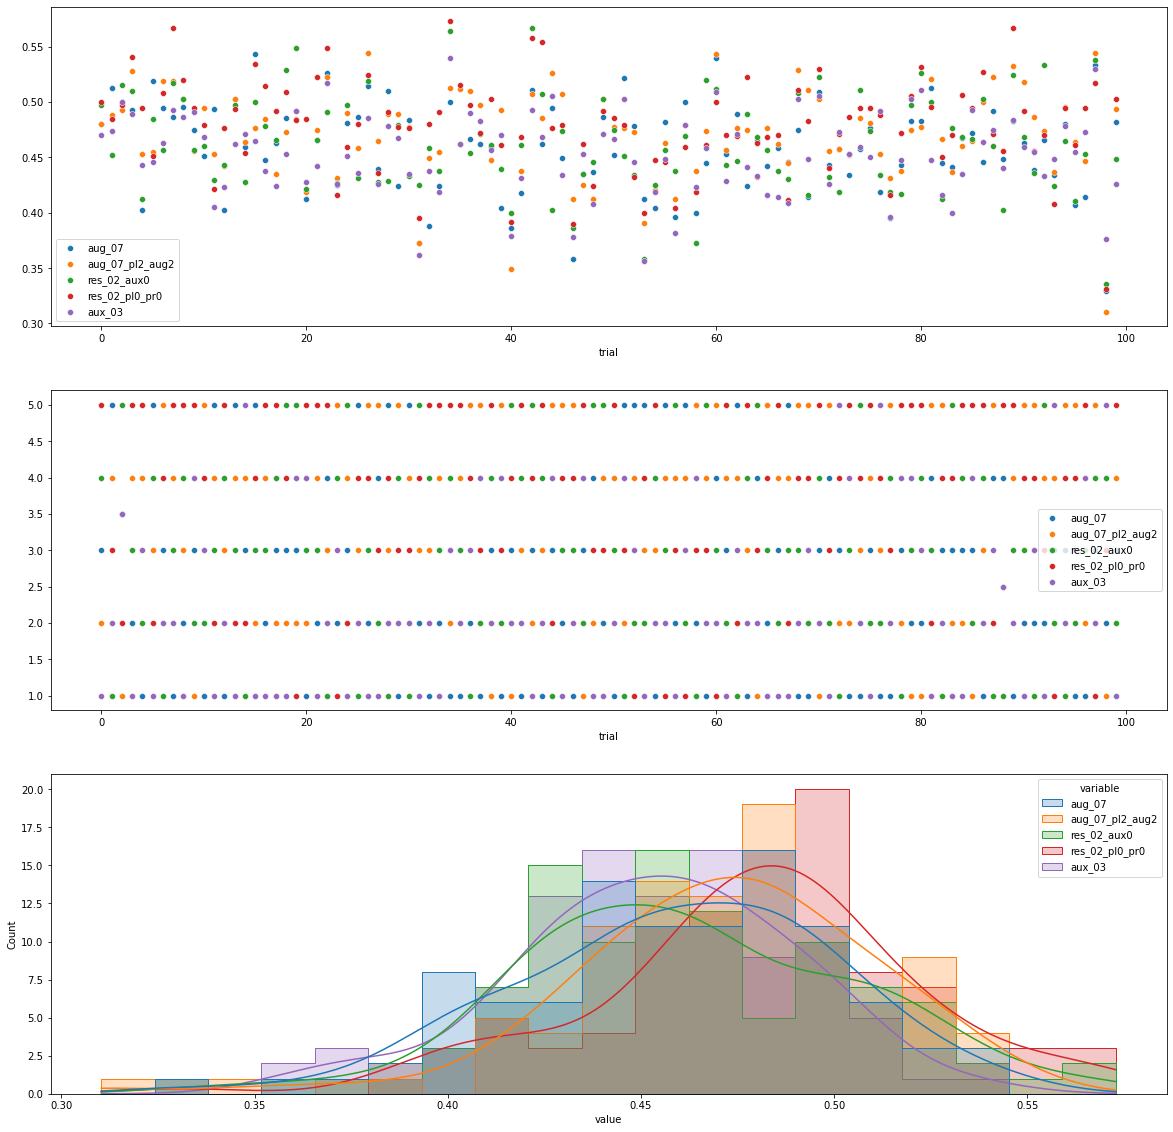

In [16]:
plt.figure(figsize=(20, 20))
plt.subplot(3, 1, 1)
for col in sens_res.columns:
    if col == 'trial':
        continue
    sns.scatterplot(x=sens_res['trial'], y=sens_res[col].values, label=col, markers='X')
plt.legend()
plt.subplot(3, 1, 2)
for col in sens_res.columns:
    if col == 'trial':
        continue
    sns.scatterplot(x=sens_res['trial'], y=sens_res.drop('trial', axis=1).rank(1)[col].values, label=col, markers='X')
plt.legend()
plt.subplot(3, 1, 3)
sns.histplot(data=sens_res.drop('trial', axis=1).melt(), x='value', hue='variable', kde=True, element="step", legend=True)
# plt.legend()
plt.savefig('sens_res.png', facecolor='white')
# plt.show()

In [15]:
agg_df = aggregate_results(Res02Aux0)
metric.optimal_f1(agg_df['label'].values, (agg_df['pred']))

(0.470723306544202, 0.26)

In [19]:
agg_df = aggregate_results(Aug07pl2aug2())
display(subgroup_analysis(agg_df, 'site'))
display(subgroup_analysis(agg_df, 'machine_id'))


,value,PF1,AUC
0,site_overall,"(0.47374062165058944, 0.19)",0.904948
1,site_1,"(0.3807339449541284, 0.24)",0.877522
2,site_2,"(0.5804988662131518, 0.21)",0.927149


,value,PF1,AUC
0,machine_id_overall,"(0.47374062165058944, 0.19)",0.904948
1,machine_id_21,"(0.5954198473282443, 0.21)",0.923716
2,machine_id_29,"(0.5599999999999999, 0.16)",0.927818
3,machine_id_48,"(0.6174496644295302, 0.31)",0.938773
4,machine_id_49,"(0.39493670886075943, 0.26)",0.86656
5,machine_id_93,"(0.33333333333333337, 0.52)",0.779507
6,machine_id_170,"(0.5555555555555556, 0.19)",0.95914
7,machine_id_190,"(0.5, 0.03)",0.960784
8,machine_id_197,NaN,NaN
9,machine_id_210,NaN,NaN


In [35]:
agg_df = aggregate_results(Aug07)
display(subgroup_analysis(agg_df, 'site'))
display(subgroup_analysis(agg_df, 'machine_id'))


,value,PF1,AUC
0,site_overall,"(0.4669703872437358, 0.25)",0.879401
1,site_1,"(0.3711790393013101, 0.25)",0.849230
2,site_2,"(0.5714285714285715, 0.25)",0.904431


,value,PF1,AUC
0,machine_id_overall,"(0.4669703872437358, 0.25)",0.879401
1,machine_id_21,"(0.5217391304347826, 0.18)",0.906191
2,machine_id_29,"(0.5555555555555556, 0.16)",0.907058
3,machine_id_48,"(0.641025641025641, 0.25)",0.905984
4,machine_id_49,"(0.38004750593824227, 0.25)",0.8444
5,machine_id_93,"(0.33333333333333337, 0.84)",0.749676
6,machine_id_170,"(0.5217391304347826, 0.12)",0.934946
7,machine_id_190,"(0.03773584905660378, 0.0)",0.745098
8,machine_id_197,NaN,NaN
9,machine_id_210,NaN,NaN


In [28]:
agg_df = aggregate_results(AuxLoss00)
display(subgroup_analysis(agg_df, 'site'))
display(subgroup_analysis(agg_df, 'machine_id'))


,value,PF1,AUC
0,site_overall,"(0.43645083932853723, 0.3)",0.881930
1,site_1,"(0.36448598130841126, 0.3)",0.844627
2,site_2,"(0.5225653206650832, 0.25)",0.916229


,value,PF1,AUC
0,machine_id_overall,"(0.43645083932853723, 0.3)",0.88193
1,machine_id_21,"(0.5027932960893856, 0.06)",0.923085
2,machine_id_29,"(0.5323741007194244, 0.25)",0.910674
3,machine_id_48,"(0.5655172413793104, 0.35000000000000003)",0.916046
4,machine_id_49,"(0.3869346733668341, 0.3)",0.837247
5,machine_id_93,"(0.33333333333333337, 0.65)",0.833982
6,machine_id_170,"(0.3636363636363636, 0.08)",0.853763
7,machine_id_190,"(0.03773584905660378, 0.0)",0.941176
8,machine_id_197,NaN,NaN
9,machine_id_210,NaN,NaN


In [29]:
agg_df = aggregate_results(Res00aug0)
display(subgroup_analysis(agg_df, 'site'))
display(subgroup_analysis(agg_df, 'machine_id'))


,value,PF1,AUC
0,site_overall,"(0.4675324675324676, 0.42)",0.903614
1,site_1,"(0.375, 0.39)",0.870219
2,site_2,"(0.57002457002457, 0.29)",0.930831


,value,PF1,AUC
0,machine_id_overall,"(0.4675324675324676, 0.42)",0.903614
1,machine_id_21,"(0.6016260162601627, 0.4)",0.936075
2,machine_id_29,"(0.523489932885906, 0.18)",0.905955
3,machine_id_48,"(0.611764705882353, 0.16)",0.950141
4,machine_id_49,"(0.38482384823848237, 0.37)",0.85749
5,machine_id_93,"(0.28571428571428575, 0.77)",0.894942
6,machine_id_170,"(0.5333333333333333, 0.42)",0.945968
7,machine_id_190,"(0.6666666666666666, 0.03)",0.980392
8,machine_id_197,NaN,NaN
9,machine_id_210,NaN,NaN


# Stability analysis

In [8]:
res = aggregate_results(Baseline4)
res.head()

NameError: name 'aggregate_results' is not defined

In [12]:
metric = Pfbeta(binarize=True)

In [14]:
metric.optimal_f1(res['label'], res['pred'])

(0.43966547192353644, 0.34)

In [15]:
res['pred_bin'] = (res['pred'] > 0.34).astype(int)

In [24]:
scores = []
for i in tqdm(range(1000)):
    res_sample = res.sample(2200*2) # per breast
    scores.append(metric.pfbeta(res_sample['label'].values, res_sample['pred_bin'].values))

  0%|          | 0/1000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Count'>

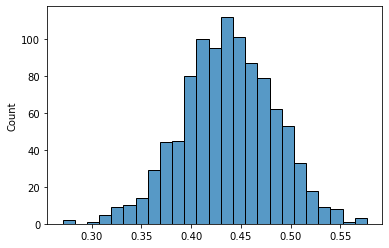

In [25]:
sns.histplot(scores)

# Use metadata ? 

In [17]:
from sklearn.linear_model import LogisticRegression

In [30]:
for fold_i, (folds, pred_fold) in enumerate(zip(predictions['folds'], predictions['outoffolds'])):
    ds = cfg.dataset(df=train.iloc[folds[1]], image_dir=None)
    labels = ds.get_labels()
    pred = sigmoid(pred_fold).reshape(-1)
    print(metric.optimal_f1(labels, pred))
    stack_x = pd.DataFrame({
        'pred': pred,
        'age': [ds.df_dict[ds.pids[i]]['age'].values[0] / 100 for i in range(len(ds))]
    })
    stack_x['age'] = stack_x['age'].fillna(stack_x['age'].mean())
    model = LogisticRegression()
    model.fit(stack_x, labels.reshape(-1))
    pred2 = model.predict_proba(stack_x)[:, 1]
    print(metric.optimal_f1(labels, pred2))
    

(0.425, 0.64)
(0.42236024844720493, 0.22)
(0.4174757281553398, 0.13)
(0.4161849710982659, 0.05)
(0.5681818181818182, 0.31)
(0.5654450261780104, 0.05)
(0.5, 0.28)
(0.48837209302325585, 0.09)
(0.42276422764227634, 0.65)
(0.42975206611570244, 0.39)


# Segmentation

In [5]:
cfg = Model11()
train = pd.read_csv(cfg.train_path)
dataset = cfg.dataset(
    df=train, 
    image_dir=cfg.image_dir,
    preprocess=cfg.preprocess['test'],
    transforms=cfg.transforms['test'],
    is_test=True,
)

NameError: name 'Model11' is not defined

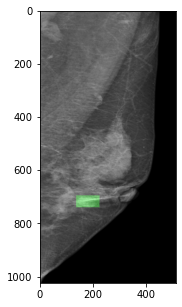

In [7]:
img, mask = dataset[7]
img = (img - img.min()) / (img.max() - img.min())
plt.figure(figsize=(5, 5))
plt.imshow(torch.concat([img, img, img], dim=0).permute(1, 2, 0) * 0.7 + mask.permute(1,2,0) * 0.3)
plt.show()
plt.close()

In [8]:
model = cfg.model(**cfg.model_params)
model.eval()
with torch.no_grad():
    pred = model(img[None, :, :, :])[0]

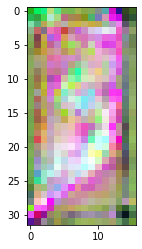

In [9]:
img = pred.permute(1, 2, 0)
# img = (img - img.amin()) / (img.amax() - img.amin())
plt.imshow(img)
plt.show()

In [10]:
pred[0].mean()

tensor(0.6946)